In [2522]:
from sympy import init_session
import math
import matplotlib.pyplot as plt
import sys
import ipywidgets as widgets
import numpy as np
import imageio.v2 as imageio
from IPython.display import Image
import pandas as pd
import seaborn as sns
import scipy.integrate as it
init_session(use_latex = True)

IPython console for SymPy 1.13.2 (Python 3.10.1-64-bit) (ground types: gmpy)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.13.2/



In [2523]:
# Size
a = 1.97 * 0.0254 #m R2
b = 12.4 * 0.0254 #m R3
c = 3.17 * 0.0254 #m R4
d = 13.4 * 0.0254 #m R1
a, b, c, d

In [2524]:
m = 3.48 #kg
l = 24.5 * 0.0254 #length of wiper m
I = 1/12 * m * l**2 + m * (l/2)**2 + 1/3 * m * l**2#moment of inertia about com kgm^2
mu_k = 0.3  # coefficient of kinetic friction
g = 9.81  # gravity (m/s^2)
theta = 23 #degs
l

In [2525]:
#Parameters
motor_torque = 30 #NM 
df = pd.read_csv("4bardata.txt", sep='\t' , header = None, names = ["time [s]", "theta_2 [rad]", "theta_3 [rad]", "theta_4 [rad]", "theta_2 [°]","theta_3 [°]","theta_4 [°]","omega_2 [rad/s]", "omega_43 [rad/s]","omega_4 [rad/s]","alpha_2 [rad/s^2]","alpha_3 [rad/s^2]","alpha_4 [rad/s^2]"])
#df.head(20)
#print(df.shape[0])


In [2526]:
#Torque Calculations
theta_a = []
tau_out = []
theta_b = []
for i in range(df.shape[0]):
    theta_a = abs(180 - (df["theta_2 [°]"][i] + df["theta_3 [°]"][i])) # inner angle between link a and b
    theta_a_edge = abs(180 - df["theta_2 [°]"][i] - df["theta_3 [°]"][i]) # inner angle between link a and b edge case
    theta_b = abs(df["theta_4 [°]"][i]- df["theta_3 [°]"][i]) # inner angle between link b and c
 
    temp1 = motor_torque * (c * np.sin(np.radians(theta_b)))/ (a * np.sin(np.radians(theta_a)))
    tau_out.append(temp1)
df["Input_Torque [nm]"] = tau_out

In [2527]:
# Equations of Motion
acceleration_t = []
force_spring = []
alpha_w = []
F_n = []
F_friction = []

for i in range(df.shape[0]):
    temp7 = 1/I * (df["Input_Torque [nm]"][i] + (l/2)* m * g * np.cos(np.radians(theta))) #alpha
    alpha_w.append(temp7)
    
    temp8 = l * alpha_w[i] #use a = r*alpha to find tangential acceleration
    acceleration_t.append(temp8)
    
    temp9 = l * (df["Input_Torque [nm]"][i]) + m * acceleration_t[i] #friction
    F_friction.append(temp8)

    temp10 = F_friction[i] / mu_k #Normal force
    F_n.append(temp10)
    
    temp11 = F_n[i] - m * g * np.cos(np.radians(theta)) #Spring Force
    force_spring.append(temp11)
    
df["F_normal [N]"] = F_n
df["Friction [N]"] = F_friction
df["acc_tan [m/s^2]"] = acceleration_t
df["alpha_w [rad/s^2]"] = alpha_w
df["F_spring [N]"]= force_spring
df.head()

,time [s],theta_2 [rad],theta_3 [rad],theta_4 [rad],theta_2 [°],theta_3 [°],theta_4 [°],omega_2 [rad/s],omega_43 [rad/s],omega_4 [rad/s],alpha_2 [rad/s^2],alpha_3 [rad/s^2],alpha_4 [rad/s^2],Input_Torque [nm],F_normal [N],Friction [N],acc_tan [m/s^2],alpha_w [rad/s^2],F_spring [N]
0,0.00,4.712389,0.374592,2.197779,270.000000,21.462533,125.923486,6.81,0.655531,-4.067483,0.0,-10.640384,-4.887655,50.227626,138.542166,41.562650,41.562650,66.788767,107.117234
1,0.01,4.712389,0.374592,2.197779,270.000000,21.462533,125.923486,6.81,0.655531,-4.067483,0.0,-10.640384,-4.887655,50.227626,138.542166,41.562650,41.562650,66.788767,107.117234
2,0.02,4.780489,0.380609,2.156869,273.901843,21.807267,123.579504,6.81,0.547185,-4.113627,0.0,-11.020230,-4.328158,52.450953,143.675438,43.102631,43.102631,69.263428,112.250507
3,0.03,4.848589,0.385524,2.115527,277.803685,22.088886,121.210765,6.81,0.435307,-4.153755,0.0,-11.345834,-3.681429,54.977773,149.509421,44.852826,44.852826,72.075890,118.084490
4,0.04,4.916689,0.389305,2.073817,281.705528,22.305527,118.820983,6.81,0.320474,-4.186905,0.0,-11.609664,-2.929573,57.860546,156.165239,46.849572,46.849572,75.284544,124.740308


In [2528]:
#Use trapezoidal rule to find v by integration
dt = 0.01
v_tan = it.cumulative_trapezoid(y = df["acc_tan [m/s^2]"], x = df["time [s]"], dx = dt, initial = 0)
#v_nor = it.cumulative_trapezoid(y = df["acc_nor [m/s^2]"], x = df["time [s]"], dx = dt, initial = 0)
df["vel_tan [m/s]"] = v_tan
#df["vel_nor [m/s]"] = v_nor


In [2529]:
#Use trapezoidal rule to find position by integration
dt = 0.01
tan = it.cumulative_trapezoid(y = df["vel_tan [m/s]"], x = df["time [s]"],dx = dt, initial = 0)
#nor = it.cumulative_trapezoid(y = df["vel_nor [m/s]"], x = df["time [s]"],dx = dt, initial = 0)
df["pos_tan [m]"] = tan
#df["pos_nor [m]"] = nor

In [2530]:
df.head()
list(df)

['time [s]',
 'theta_2 [rad]',
 'theta_3 [rad]',
 'theta_4 [rad]',
 'theta_2 [°]',
 'theta_3 [°]',
 'theta_4 [°]',
 'omega_2 [rad/s]',
 'omega_43 [rad/s]',
 'omega_4 [rad/s]',
 'alpha_2 [rad/s^2]',
 'alpha_3 [rad/s^2]',
 'alpha_4 [rad/s^2]',
 'Input_Torque [nm]',
 'F_normal [N]',
 'Friction [N]',
 'acc_tan [m/s^2]',
 'alpha_w [rad/s^2]',
 'F_spring [N]',
 'vel_tan [m/s]',
 'pos_tan [m]']

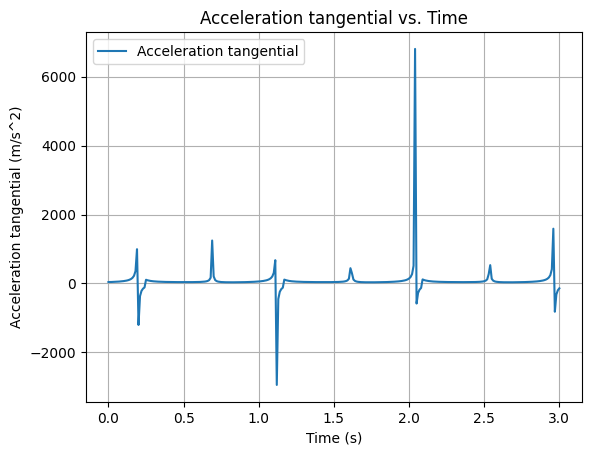

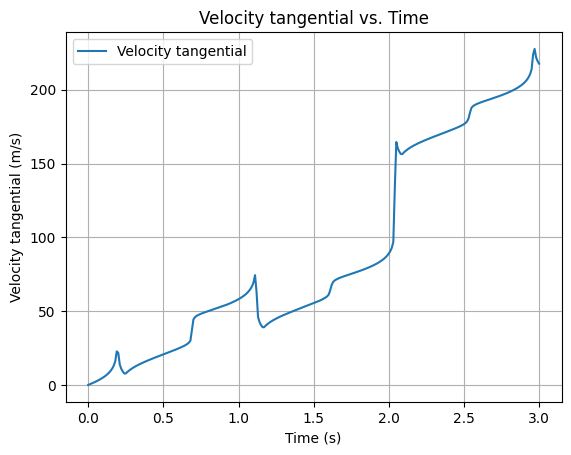

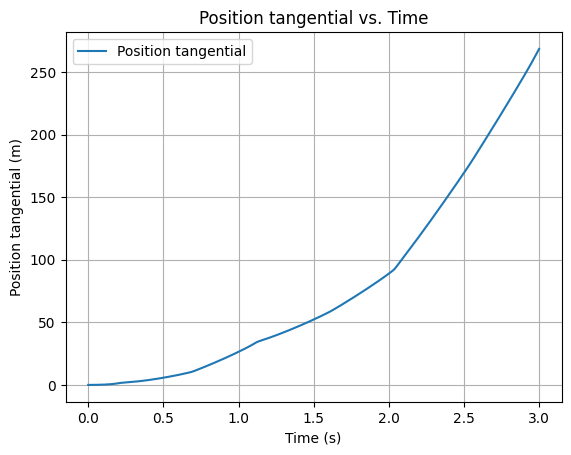

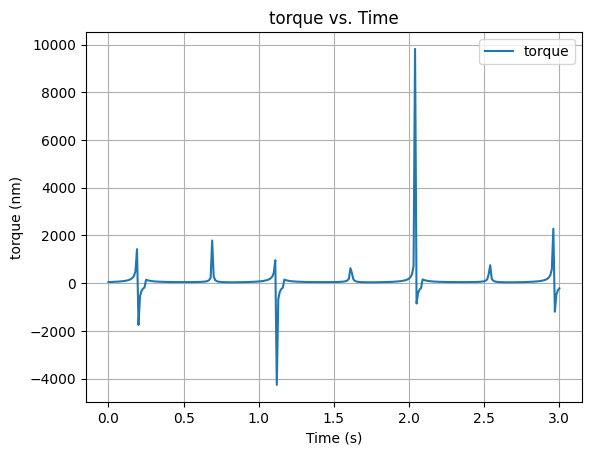

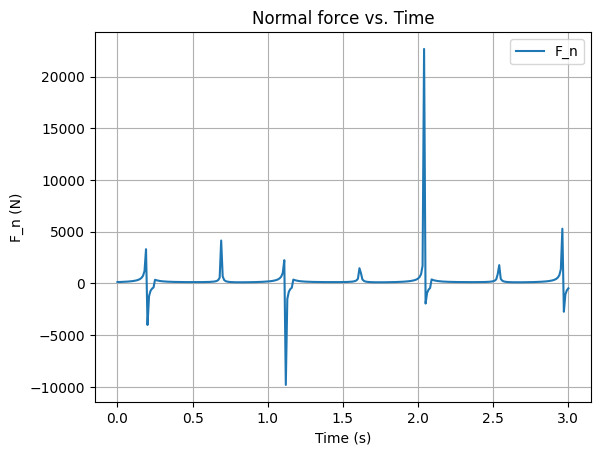

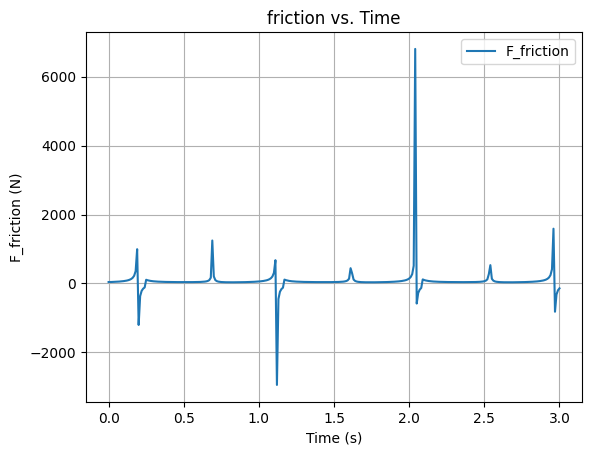

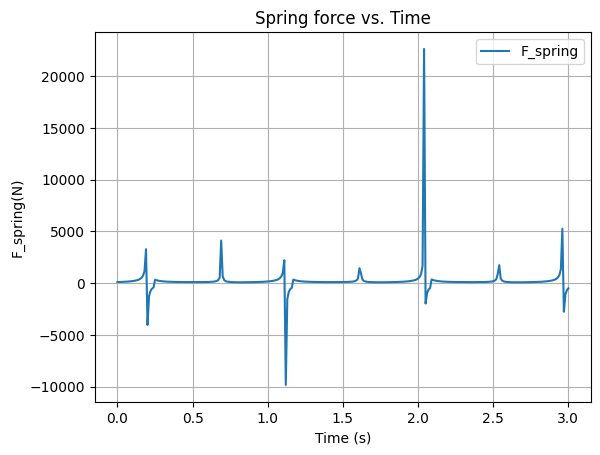

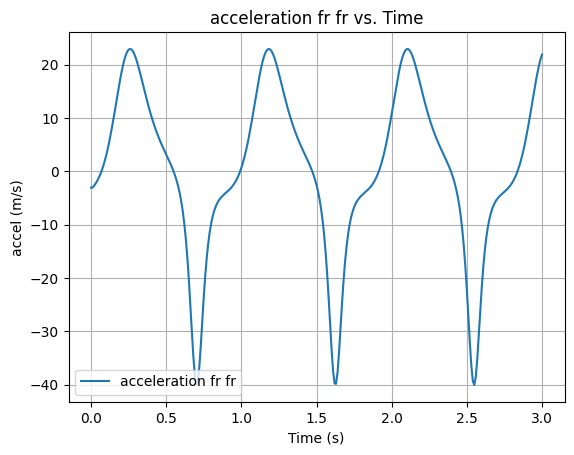

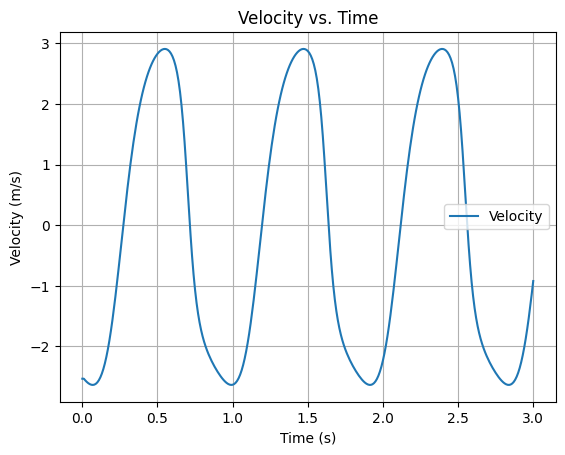

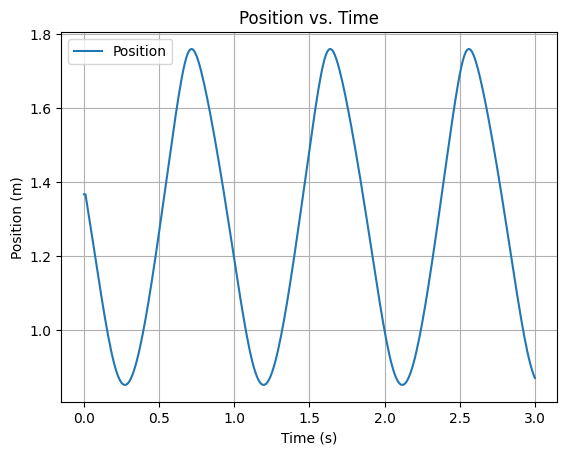

In [2531]:
# Plotting the graphs

plt.plot(df["time [s]"], df["acc_tan [m/s^2]"], label='Acceleration tangential')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration tangential (m/s^2)')
plt.title('Acceleration tangential vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["vel_tan [m/s]"] , label='Velocity tangential')
plt.xlabel('Time (s)')
plt.ylabel('Velocity tangential (m/s)')
plt.title('Velocity tangential vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["pos_tan [m]"] , label='Position tangential')
plt.xlabel('Time (s)')
plt.ylabel('Position tangential (m)')
plt.title('Position tangential vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["Input_Torque [nm]"], label='torque')
plt.xlabel('Time (s)')
plt.ylabel('torque (nm)')
plt.title('torque vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["F_normal [N]"], label='F_n')
plt.xlabel('Time (s)')
plt.ylabel('F_n (N)')
plt.title('Normal force vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["Friction [N]"], label='F_friction')
plt.xlabel('Time (s)')
plt.ylabel('F_friction (N)')
plt.title('friction vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], df["F_spring [N]"], label='F_spring')
plt.xlabel('Time (s)')
plt.ylabel('F_spring(N)')
plt.title('Spring force vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], l * df["alpha_4 [rad/s^2]"], label='acceleration fr fr')
plt.xlabel('Time (s)')
plt.ylabel('accel (m/s)')
plt.title('acceleration fr fr vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], l * df["omega_4 [rad/s]"], label='Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(df["time [s]"], l * df["theta_4 [rad]"], label='Position')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Position vs. Time')
plt.legend()
plt.grid()
plt.show()